In [34]:
from typing import List

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import numpy as np
import pandas as pd

from plasticc.dataset import Dataset

import plasticc.metrics as metrics

In [60]:
!pip install catboost==0.11.1

  Using cached https://files.pythonhosted.org/packages/19/ea/d6cbdf03fb1e8ea8c7c7a0b37b89c8f8b3825ec625d428d49b6230656c00/catboost-0.11.1-cp36-none-manylinux1_x86_64.whl
  Found existing installation: catboost 0.5.2.1
    Uninstalling catboost-0.5.2.1:
      Successfully uninstalled catboost-0.5.2.1


In [2]:
ds_tsfresh = Dataset('../data/sets/tsfresh-sample/', y_colname='target')

In [3]:
ds_simple = Dataset('../data/sets/simple-12-01/', y_colname='target')

In [4]:
Xt, yt = ds_tsfresh.train

In [5]:
Xs, ys = ds_simple.train

### Eliminate null values

In [6]:
def null_values(X: pd.DataFrame) -> List[str]:
    print("Total columns:", len(X.columns))
    na_cols = [col for col in X.columns if X[col].isna().any()]
    print("Total NA columns: ", len(na_cols))
    if len(na_cols) < 10:
        print("NA values by column:")
        print({na_col: X[na_col].isna().sum() for na_col in na_cols})
    return na_cols

In [7]:
na_tsfresh = null_values(Xt)

Total columns: 1065
Total NA columns:  1
NA values by column:
{'distmod': 2325}


In [8]:
na_simple = null_values(Xs)

Total columns: 176
Total NA columns:  1
NA values by column:
{'distmod': 2325}


We will fill null values with 0 and remove values that were duplicated

In [9]:
for X in [Xs, Xt]:
    X.fillna(0, inplace=True)
#     X.dropna(axis=1, inplace=True)
    assert(X.notna().all().all())
    X.drop(columns=[col for col in set(X.columns) if col.endswith('_meta')], inplace=True)

### Eliminate inifinte values

In [10]:
for X in [Xs, Xt]:
    print("Before infinity removal:", X.shape)
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    na_cols = null_values(X)
    X.drop(columns=na_cols, inplace=True)
    print("After infinity removal:", X.shape)

Before infinity removal: (7848, 176)
Total columns: 176
Total NA columns:  0
NA values by column:
{}
After infinity removal: (7848, 176)
Before infinity removal: (7848, 1064)
Total columns: 1064
Total NA columns:  0
NA values by column:
{}
After infinity removal: (7848, 1064)


### Train models on simple dataset

In [11]:
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
def plot_feature_importances(model, feature_names: List[str]):
    features = pd.DataFrame({"Importance": model.feature_importances_, "Feature": feature_names})
    fig, ax = plt.subplots(figsize=(6,15))
    sns.barplot(ax=ax, x='Importance', y='Feature', data=features.sort_values(by='Importance', ascending=False).head(50))
    sns.despine(left=True, bottom=True)
    plt.show()

In [13]:
X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size=0.15, random_state=42)

In [14]:

def xgb_kaggle_loss(y_true, y_pred, **kwargs):
    
    y_true = y_true.reshape(-1, 1)
    y_true = OneHotEncoder(sparse=False).fit_transform(y_true)
    print(y_true)
    out = metrics.wtf_xgb_kaggle_loss(y_true, y_pred, **kwargs)
    print(out)
    return out

In [50]:
xgb_model = XGBClassifier(max_depth=7,
                           min_child_weight=10,
                           learning_rate=0.03,
                           n_estimators=1000,
                           silent=True,
                           objective= 'multi:softprob',
                           #objective = xgb_kaggle_loss,
                           # gamma=0.01,
                           max_delta_step=0,
                           subsample=0.9,
                           colsample_bytree=0.5,
                           colsample_bylevel=1,
                           reg_alpha=0.01,
                           reg_lambda=0.01,
                           scale_pos_weight=1,
                           seed=1,
                           missing=None)

cat_model = CatBoostClassifier(
                         learning_rate=0.3,
                         loss_function='MultiClass',
                         random_seed=3721,
                         max_depth=7,
                         n_estimators=1000,
                         reg_lambda=0.1,
                         logging_level='Verbose'
#                         scale_pos_weight=1,
)

In [16]:
# TODO: Class weights for training and for eval

In [52]:
%%time
#xgb_model.fit(X_train, y_train, verbose=100, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=50)
cat_model.fit(X_train, y=y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=50)

0:	learn: -1.4601623	test: -1.4601623	test1: -1.4332784	best: -1.4332784 (0)	total: 1.94s	remaining: 32m 13s
1:	learn: -1.2727441	test: -1.2727441	test1: -1.2571200	best: -1.2571200 (1)	total: 3.96s	remaining: 32m 58s
2:	learn: -1.1521079	test: -1.1521079	test1: -1.1452044	best: -1.1452044 (2)	total: 5.93s	remaining: 32m 50s
3:	learn: -1.0765283	test: -1.0765283	test1: -1.0687620	best: -1.0687620 (3)	total: 7.93s	remaining: 32m 56s
4:	learn: -1.0110795	test: -1.0110795	test1: -1.0099105	best: -1.0099105 (4)	total: 10s	remaining: 33m 11s
5:	learn: -0.9496952	test: -0.9496952	test1: -0.9625091	best: -0.9625091 (5)	total: 12.1s	remaining: 33m 20s
6:	learn: -0.9014772	test: -0.9014772	test1: -0.9202321	best: -0.9202321 (6)	total: 14.1s	remaining: 33m 16s
7:	learn: -0.8729537	test: -0.8729537	test1: -0.8920104	best: -0.8920104 (7)	total: 16.1s	remaining: 33m 10s
8:	learn: -0.8488541	test: -0.8488541	test1: -0.8741457	best: -0.8741457 (8)	total: 18s	remaining: 33m 6s
9:	learn: -0.8237106	tes

In [54]:
cat_model.score(X_test, y_test)

CatboostError: catboost/libs/labels/external_label_helper.cpp:80: Can't convert bad label back to class name.

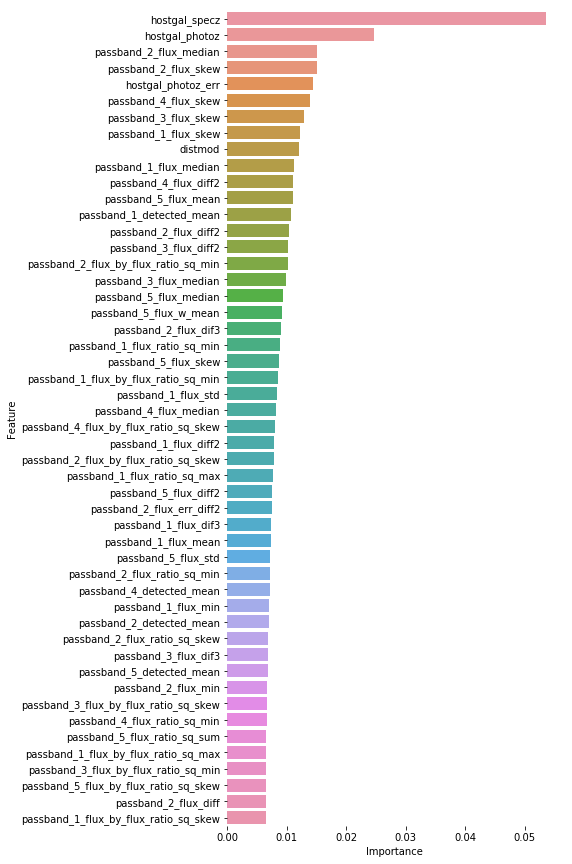

In [19]:
plot_feature_importances(xgb_model, X_test.columns)

### Train model on tsfresh dataset

In [20]:
#TODO

### Calculate feature imporatnce for selecting optimal tsfresh features

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import describe
import tsfresh
import pandas as pd

In [22]:
def to_tsfresh_format(feature_set: set, train_X: pd.DataFrame) -> dict:
    """ Converts a set of features names into tsfresh-acceptable settings dict. """
    df_selected = train_X[list(feature_set)]
    return tsfresh.feature_extraction.settings.from_columns(df_selected)

def select_features_from_trained_model(model, train_X: pd.DataFrame, meta_columns: set, verbose=True) -> set:
    """
    Extracts a set of relevant features from trained model.
    Parameters:
    - train_X should be the X used to train the model
    - meta_columns should contain column names that will be excluded from the tsfresh selection (columns from metadata, not the time series)
    """
    print(describe(model.feature_importances_))
    features = pd.Series(model.feature_importances_, index=train_X.columns)
    print("Most relevant features for the model:", features.sort_values().tail(10))
    # calculating how much data is lost based on minimal importance level
    N_THRESHOLDS = 1000
    select_crit = np.zeros(N_THRESHOLDS)
    select_min = np.zeros(N_THRESHOLDS)
    for i, q in enumerate(np.linspace(features.min(), features.max(), N_THRESHOLDS, endpoint=False)):
        selected = features[features > q]
        select_crit[i] = selected.min() * len(selected) / len(features)
        select_min[i] = selected.min()
    # choosing minimum importance level that maximizes (selected feature count * minimal selected feature importance)
    min_importance = select_min[np.argmax(select_crit)]
    selected_features = set(features[features > min_importance].index) - meta_columns
    if verbose:
        print(f"Selected minimal importance: {min_importance}", f"Number of selected features: {len(selected_features)}")
        plt.plot(select_crit)
        plt.show()
    return selected_features, features

In [23]:
meta_columns = set(Dataset('../data/sets/base/').train_meta.columns)

In [24]:
xgb_fset, xgb_feature_importance = select_features_from_trained_model(model1, X, meta_columns)

NameError: name 'model1' is not defined

In [ ]:
skl_fset, skl_feature_importance = select_features_from_trained_model(model2, X, meta_columns)

In [ ]:
important_for_both = xgb_fset & skl_fset

In [ ]:
len(important_for_both)

In [ ]:
common_dict = to_tsfresh_format(important_for_both, X)

In [ ]:
type(common_dict)

#### Decrease number of features
There are some inconsistencies when it comes to which features are extracted for which series.
We will limit extracted features to those relevant for most of the 6 series for now.

In [ ]:
keyset = set()
for i in range(6):
    keyset |= set(common_dict[str(i)].keys())

In [ ]:
len(keyset)

In [ ]:
feature_counts = dict()
for feature in keyset:
    for i in range(6):
        for key in common_dict[str(i)].keys():
            if feature in key:
                try:
                    feature_counts[feature] += 1
                except KeyError:
                    feature_counts[feature] = 1

In [ ]:
feature_counts = pd.Series(feature_counts)

In [ ]:
feature_counts.sort_values(ascending=False)

In [ ]:
feature_counts.sort_values(ascending=False).mean()

In [ ]:
final_features = set(feature_counts[feature_counts > 4].index)

In [ ]:
final_features

### Save feature dict for tsfresh feature generator to use

In [ ]:
import pickle

from tsfresh.feature_extraction.settings import ComprehensiveFCParameters

In [ ]:
settings = ComprehensiveFCParameters()
comprehensive_keys = set(settings.keys())
for key in comprehensive_keys:
    if key not in final_features:
        del settings[key]

In [ ]:
with open('../data/config/tsfresh-settings.pkl', 'wb+') as file:
    pickle.dump(settings, file)

In [ ]:
model1.classes_